In [2]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import pandas as pd
import pytz
import xarray

from config import poa_data_path, MAURITIUS_CONTOUR_FILE, data_path, best_transposition_factor_path
from utils import plot_map

tz = pytz.timezone("Etc/GMT+4")
date_range = [
    datetime(2019, 1, 1),
    datetime(2020, 1, 1) - timedelta(minutes=30)
]

azimuth_range = range(-180, 190, 10)
tilt_range = range(0, 100, 10)


def get_poa_for_azimuth_tilt(azimuth, tilt, date_range):
    poa = xarray.open_dataset(poa_data_path / f"{tilt}_{azimuth}.nc")
    poa = poa.to_dataframe().reset_index().set_index("time")
    poa = poa[date_range[0]:date_range[1]].groupby(['lat', 'lon']).mean().reset_index()
    return poa


In [2]:
% matplotlib widget

# Visualizing POA irradiance over a year with flat panel

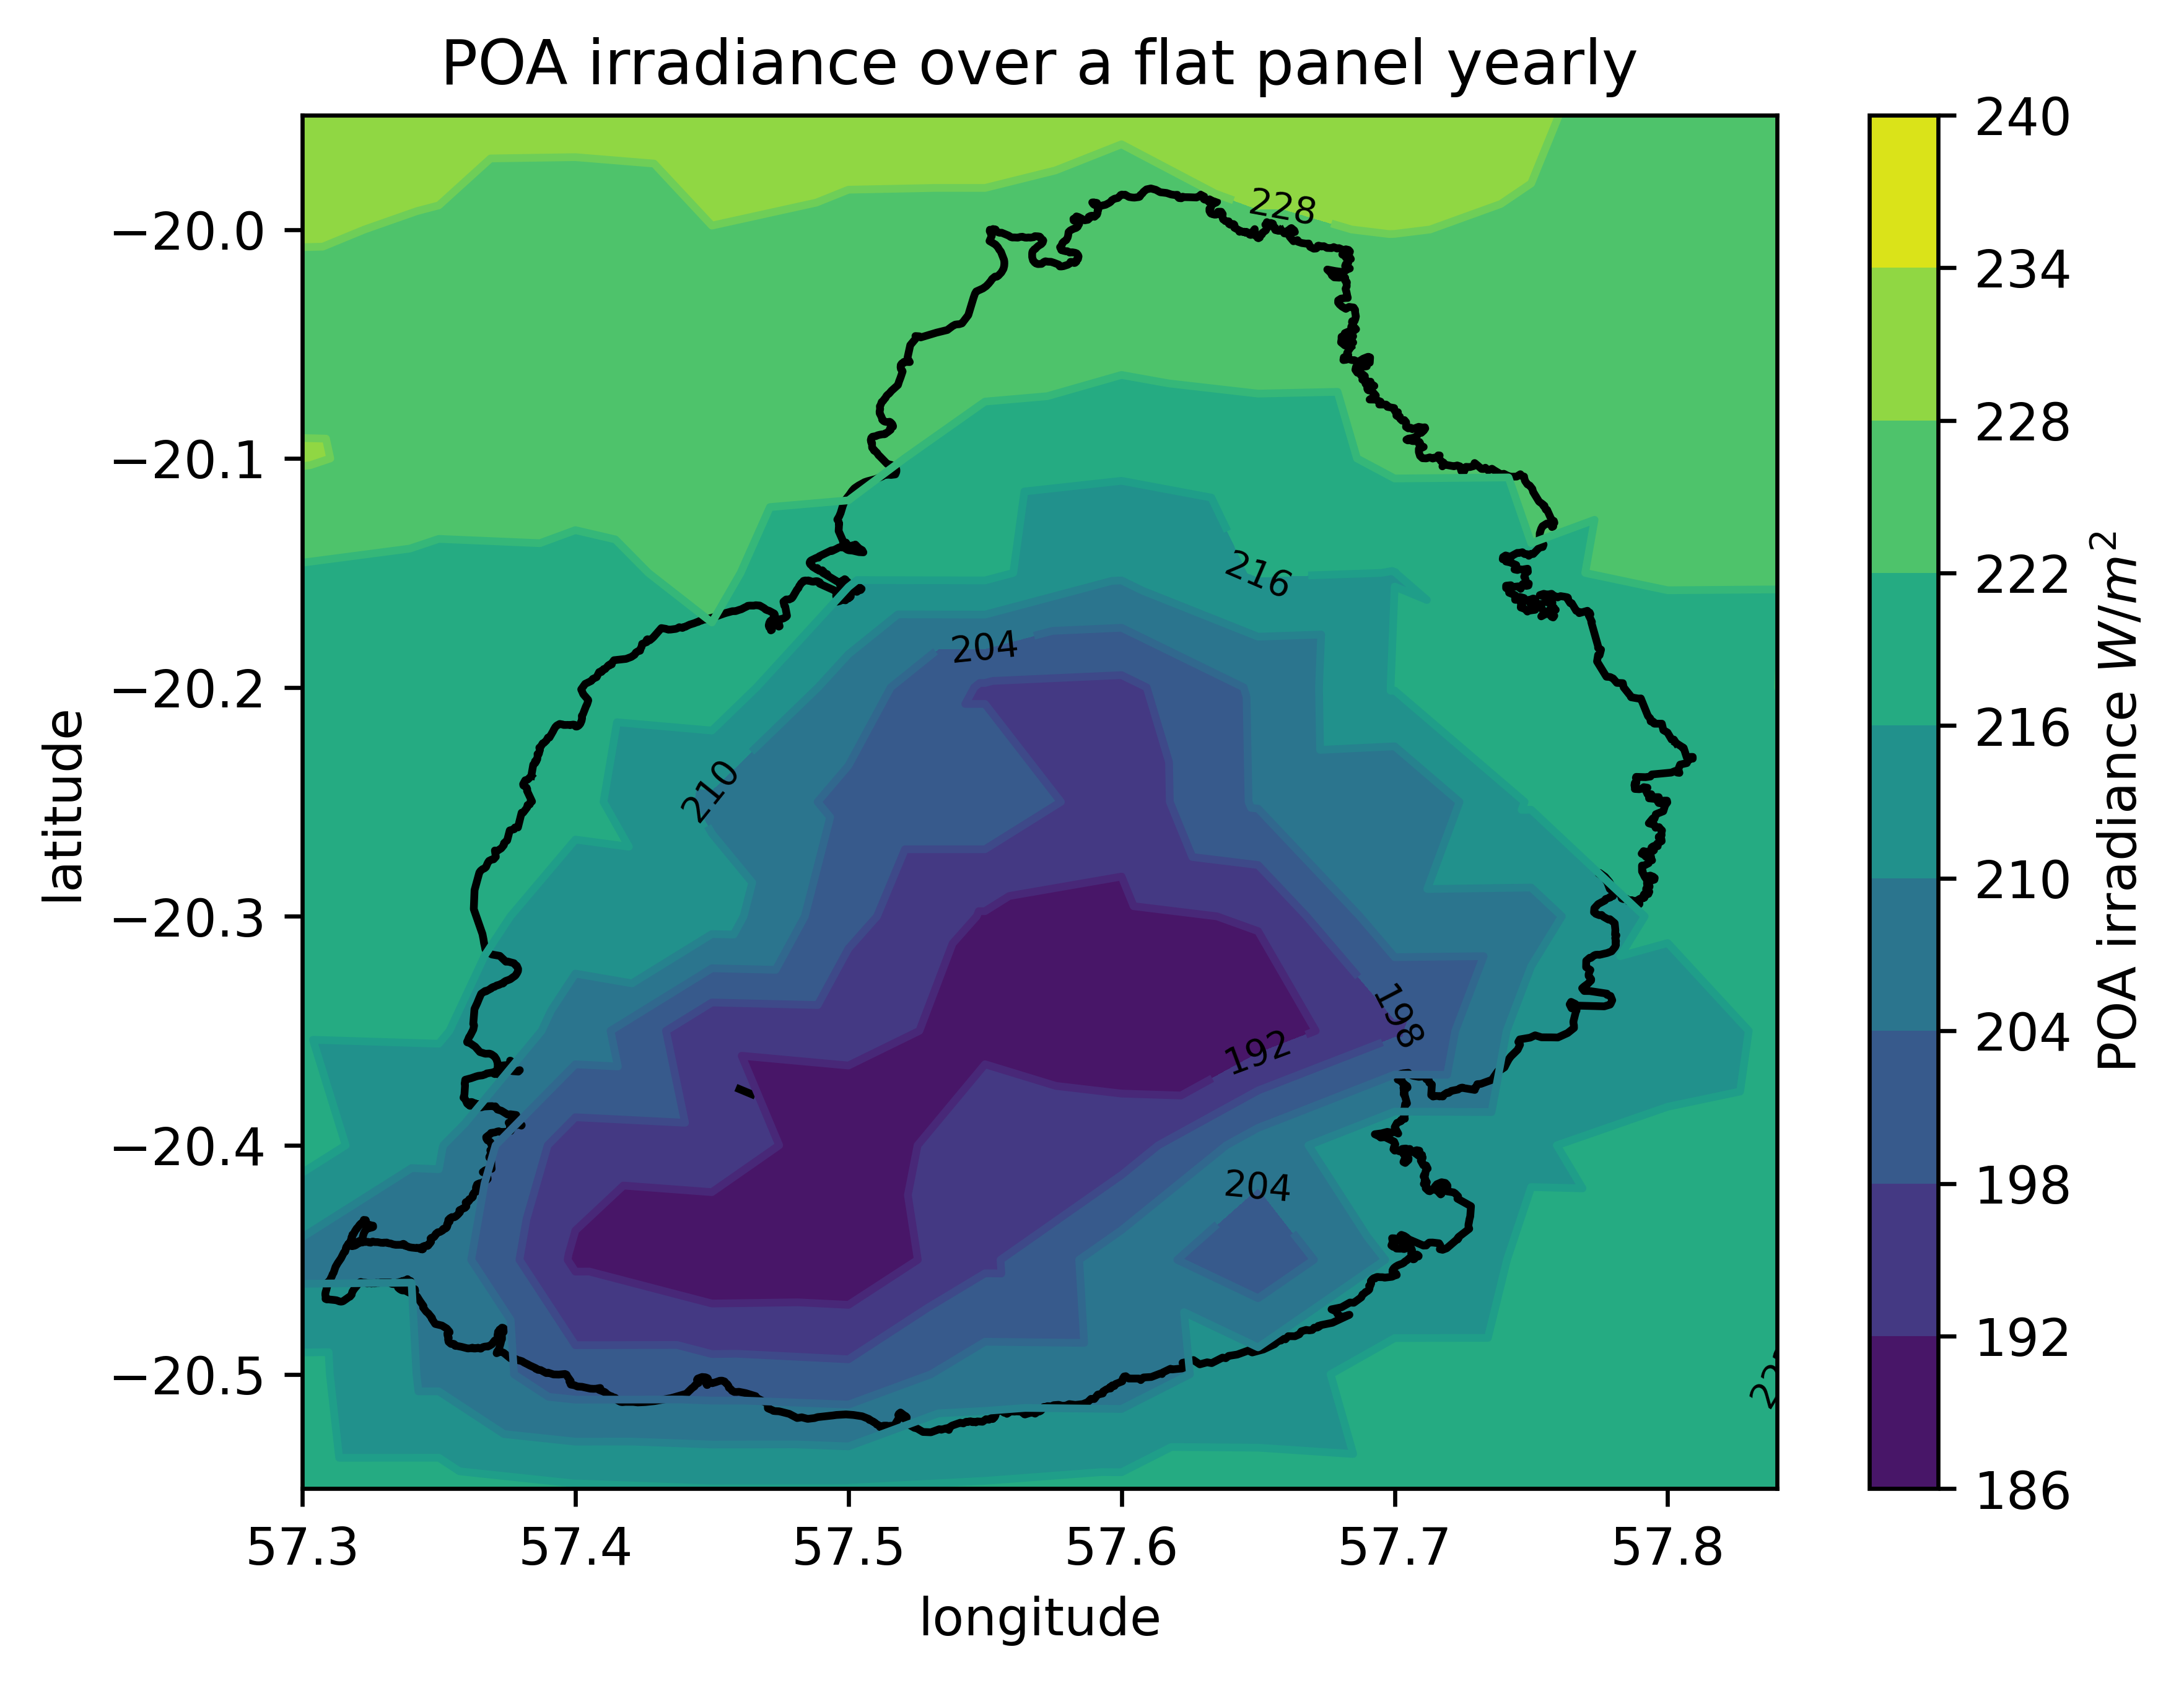

In [10]:
poa_0_0 = get_poa_for_azimuth_tilt(0, 0, date_range)
fig = plt.figure()
fig.set_dpi(600)
ax = fig.add_subplot()
ax.set_title(f"POA irradiance over a flat panel yearly")
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plot_map(ax, MAURITIUS_CONTOUR_FILE)

contourf = ax.tricontourf(poa_0_0['lon'], poa_0_0['lat'], poa_0_0['POA_GLOBAL_IRRADIANCE'], )
contour = ax.tricontour(poa_0_0['lon'], poa_0_0['lat'], poa_0_0['POA_GLOBAL_IRRADIANCE'], )

ax.clabel(contour, inline=1, fontsize=7, colors='black')
plt.xlim([57.3, 57.84])
plt.ylim([-20.55, -19.95])
fig.colorbar(contourf, label='POA irradiance $W/m^2$')
plt.show()

In [25]:
def get_transposition_factor(azimuth, tilt, poa_0_0, date_range):
    poa = get_poa_for_azimuth_tilt(azimuth, tilt, date_range)
    transposition_factor = poa["POA_GLOBAL_IRRADIANCE"] / poa_0_0["POA_GLOBAL_IRRADIANCE"]
    poa["transposition_factor"] = transposition_factor
    return poa


def select_lat_lon(df, lat, lon):
    return df[(df["lat"] == lat) & (df["lon"] == lon)]

# Finding best transposition factor for a date_range

In [26]:
from tqdm import tqdm


def calculate_best_transposition_factor(azimuth_range, tilt_range, date_range):
    poa_0_0 = get_poa_for_azimuth_tilt(0, 0, date_range)
    best_transposition_factor = pd.DataFrame(
        columns=["lat", "lon", "transposition_factor", "tilt", "azimuth", "POA_GLOBAL_IRRADIANCE"])
    for lat in poa_0_0["lat"].unique():
        for lon in poa_0_0["lon"].unique():
            # insert 0 as default value
            best_transposition_factor = pd.concat([best_transposition_factor, pd.DataFrame({
                'lat': [lat],
                'lon': [lon],
                'transposition_factor': [0],
                'tilt': [0],
                'azimuth': [0],
                'POA_GLOBAL_IRRADIANCE': [0]
            })])

    for azimuth in tqdm(azimuth_range):
        for tilt in tilt_range:
            transposition_factor = get_transposition_factor(azimuth, tilt, poa_0_0, date_range)
            for lat in transposition_factor["lat"].unique():
                for lon in transposition_factor["lon"].unique():
                    if select_lat_lon(transposition_factor, lat, lon)['transposition_factor'].values[0] > \
                            select_lat_lon(best_transposition_factor, lat, lon)['transposition_factor'].values[0]:
                        best_transposition_factor.loc[
                            (best_transposition_factor["lat"] == lat) & (
                                    best_transposition_factor["lon"] == lon), "transposition_factor"] = \
                            select_lat_lon(transposition_factor, lat, lon)['transposition_factor'].values[0]
                        best_transposition_factor.loc[
                            (best_transposition_factor["lat"] == lat) & (
                                    best_transposition_factor["lon"] == lon), "tilt"] = tilt
                        best_transposition_factor.loc[
                            (best_transposition_factor["lat"] == lat) & (
                                    best_transposition_factor["lon"] == lon), "azimuth"] = azimuth
                        best_transposition_factor.loc[
                            (best_transposition_factor["lat"] == lat) & (
                                    best_transposition_factor["lon"] == lon), "POA_GLOBAL_IRRADIANCE"] = \
                            select_lat_lon(transposition_factor, lat, lon)['POA_GLOBAL_IRRADIANCE'].values[0]
    best_transposition_factor.to_csv(
        str(best_transposition_factor_path / f"{date_range[0].date()}_{date_range[1].date()}.csv"))





'2019-12-31'

# Finding the best transposition factor for a year

In [27]:
calculate_best_transposition_factor(azimuth_range, tilt_range, date_range)

100%|██████████| 37/37 [11:24<00:00, 18.49s/it]


# Finding the best transposition factor for every month

In [16]:
from dateutil.relativedelta import relativedelta

date_range = [
    datetime(2019, 1, 1),
    datetime(2019, 2, 1) - timedelta(minutes=30)
]

for loop in range(12):
    # print(date_range)
    calculate_best_transposition_factor(azimuth_range, tilt_range, date_range)
    date_range[0] += relativedelta(months=1)
    date_range[1] = date_range[0] + relativedelta(months=1)


100%|██████████| 37/37 [06:11<00:00, 10.03s/it]


# Plotting the best POA irradiance / tilt / azimuth / transposition factor

In [39]:
from matplotlib.pyplot import close
from pathlib import Path


def plot_data(csv_data_path: Path):
    date_range = csv_data_path.parts[-1].removesuffix(".csv").split("_")

    best_tilt_azimuth = pd.read_csv(str(csv_data_path)).groupby(
        ['lat', 'lon']).mean().reset_index()
    close('all')
    fig, ax = plt.subplots()
    fig.set_dpi(500)
    ax.set_title(f"Best POA irradiance in Mauritius {date_range[0]}_{date_range[1]}", )
    ax.set_ylabel('latitude', )
    ax.set_xlabel('longitude', )

    ax.set_zorder(3)

    plot_map(ax, MAURITIUS_CONTOUR_FILE)

    contourf = ax.tricontourf(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
                              best_tilt_azimuth['POA_GLOBAL_IRRADIANCE'], )
    contour = ax.tricontour(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
                            best_tilt_azimuth['POA_GLOBAL_IRRADIANCE'], )
    ax.clabel(contour, inline=1, fontsize=7, colors='black')
    fig.colorbar(contourf, label='POA irradiance $W/m^2$', format=lambda x, _: "{:.2f}".format(x))

    plt.xlim([57.3, 57.84])
    plt.ylim([-20.55, -19.95])
    fig.savefig(data_path / f"graphs/poa-analysis/POA-{date_range[0]}_{date_range[1]}.png", bbox_inches='tight')

    close('all')
    fig, ax = plt.subplots()
    fig.set_dpi(500)

    ax.set_title(f"Best tilt for PV panel Mauritius {date_range[0]}_{date_range[1]}", )
    ax.set_ylabel('latitude', )
    ax.set_xlabel('longitude', )
    ax.set_zorder(3)

    plot_map(ax, MAURITIUS_CONTOUR_FILE)

    contourf = ax.tricontourf(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
                              best_tilt_azimuth['tilt'], vmin=list(tilt_range)[0], vmax=list(tilt_range)[-1],
                              levels=list(tilt_range))
    contour = ax.tricontour(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
                            best_tilt_azimuth['tilt'], vmin=list(tilt_range)[0], vmax=list(tilt_range)[-1],
                            levels=list(tilt_range))
    ax.clabel(contour, inline=1, fontsize=7, colors='black')
    fig.colorbar(contourf, label='Tilt in degrees', format=lambda x, _: "{:.2f}".format(x))
    contour.set_clim(vmin=list(tilt_range)[0], vmax=list(tilt_range)[-1])
    fig.text(.01, .99, f"average: {best_tilt_azimuth['tilt'].mean():.2f}", ha='left', va='top', transform=ax.transAxes)
    fig.savefig(data_path / f"graphs/poa-analysis/tilt-{date_range[0]}_{date_range[1]}.png", bbox_inches='tight')
    close('all')

    fig, ax = plt.subplots()
    fig.set_dpi(500)

    ax.set_title(f"Best azimuth for PV panel Mauritius {date_range[0]}_{date_range[1]}", )
    ax.set_ylabel('latitude', )
    ax.set_xlabel('longitude', )
    ax.set_zorder(3)

    plot_map(ax, MAURITIUS_CONTOUR_FILE)

    contourf = ax.tricontourf(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
                              best_tilt_azimuth['azimuth'], vmin=list(azimuth_range)[0], vmax=list(azimuth_range)[-1],
                              levels=list(azimuth_range))
    contour = ax.tricontour(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
                            best_tilt_azimuth['azimuth'], vmin=list(azimuth_range)[0], vmax=list(azimuth_range)[-1],
                            levels=list(azimuth_range))
    ax.clabel(contour, inline=1, fontsize=7, colors='black')
    fig.colorbar(contourf, label='Azimuth in degrees', format=lambda x, _: "{:.2f}".format(x))
    contour.set_clim(vmin=list(azimuth_range)[0], vmax=list(azimuth_range)[-1])
    fig.text(.01, .99, f"average: {best_tilt_azimuth['azimuth'].mean():.2f}", ha='left', va='top',
             transform=ax.transAxes)
    fig.savefig(data_path / f"graphs/poa-analysis/azimuth-{date_range[0]}_{date_range[1]}.png", bbox_inches='tight')

    fig, ax = plt.subplots()
    fig.set_dpi(500)

    ax.set_title(f"Best transposition factor for PV panel Mauritius {date_range[0]}_{date_range[1]}")
    ax.set_ylabel('latitude', )
    ax.set_xlabel('longitude', )
    ax.set_zorder(3)

    plot_map(ax, MAURITIUS_CONTOUR_FILE)

    contourf = ax.tricontourf(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
                              best_tilt_azimuth['transposition_factor'], )
    contour = ax.tricontour(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
                            best_tilt_azimuth['transposition_factor'], )
    ax.clabel(contour, inline=1, fontsize=7, colors='black')
    fig.colorbar(contourf, label='Transposition Factor', format=lambda x, _: "{:.2f}".format(x))
    fig.savefig(data_path / f"graphs/poa-analysis/transposition-factor-{date_range[0]}_{date_range[1]}.png",
                bbox_inches='tight')
    close('all')


In [40]:
for path in best_transposition_factor_path.iterdir():
    plot_data(path)

C:\Users\appad\AppData\Local\Temp\ipykernel_10348\2829975269.py:46: UserWarning: No contour levels were found within the data range.
  contour = ax.tricontour(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
C:\Users\appad\AppData\Local\Temp\ipykernel_10348\2829975269.py:46: UserWarning: No contour levels were found within the data range.
  contour = ax.tricontour(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
C:\Users\appad\AppData\Local\Temp\ipykernel_10348\2829975269.py:46: UserWarning: No contour levels were found within the data range.
  contour = ax.tricontour(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
C:\Users\appad\AppData\Local\Temp\ipykernel_10348\2829975269.py:46: UserWarning: No contour levels were found within the data range.
  contour = ax.tricontour(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
C:\Users\appad\AppData\Local\Temp\ipykernel_10348\2829975269.py:46: UserWarning: No contour levels were found within the data range.
  contour = ax.triconto